In [1]:
import odc.stac
import pandas as pd
import planetary_computer
import pystac_client
import xarray as xr
from pystac.extensions.eo import EOExtension as eo
import matplotlib.pyplot as plt
import numpy as np


import hvplot.xarray
import panel as pn

pn.extension()

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
catalog.title

'Microsoft Planetary Computer STAC API'

In [3]:
all_collections = [i.id for i in catalog.get_collections()]
landsat_collections = [
    collection for collection in all_collections if "landsat" in collection
]
landsat_collections

['landsat-c2-l2', 'landsat-c2-l1']

In [4]:
bbox = [30.673828,29.744109,32.005920,30.291089]  # Region over cairo, eygypt
datetime = "2024-06-01/2024-08-31"  # Summer months of 2017
collection = "landsat-c2-l2"

In [5]:
platform = "landsat-8"
cloudy_less_than = 1  # percent

In [6]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}, "platform": {"in": [platform]}},
)
items = search.item_collection()
print(f"Returned {len(items)} Items:")
item_id = {(i, item.id): i for i, item in enumerate(items)}
item_id

Returned 11 Items:


{(0, 'LC08_L2SP_176040_20240817_02_T1'): 0,
 (1, 'LC08_L2SP_176039_20240817_02_T1'): 1,
 (2, 'LC08_L2SP_177039_20240808_02_T1'): 2,
 (3, 'LC08_L2SP_176040_20240801_02_T1'): 3,
 (4, 'LC08_L2SP_176039_20240801_02_T1'): 4,
 (5, 'LC08_L2SP_177039_20240723_02_T1'): 5,
 (6, 'LC08_L2SP_176040_20240716_02_T1'): 6,
 (7, 'LC08_L2SP_176039_20240716_02_T1'): 7,
 (8, 'LC08_L2SP_177039_20240707_02_T1'): 8,
 (9, 'LC08_L2SP_177039_20240621_02_T1'): 9,
 (10, 'LC08_L2SP_177039_20240605_02_T1'): 10}

In [7]:
item_id = {(i, item.id): i for i, item in enumerate(items)}
item_sel = pn.widgets.Select(value=0, options=item_id, name="Select Item")

def get_preview(i):
    return pn.panel(items[i].assets["rendered_preview"].href, height=300)

pn.Row(item_sel, pn.bind(get_preview, item_sel)).servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'9fb1cd45-b48c-49e1-8ffc-e1a4342af0b7': {'version…

In [8]:
selected_item = items[1]
selected_item

<Item id=LC08_L2SP_176039_20240817_02_T1>

In [9]:
assets = []
for _, asset in selected_item.assets.items():
    assets.append([asset.title,asset.description])


bands = pd.DataFrame(assets, columns=["name","description"])
bands

,name,description
0,Surface Temperature Quality Assessment Band,Collection 2 Level-2 Quality Assessment Band (...
1,Angle Coefficients File,Collection 2 Level-1 Angle Coefficients File
2,Red Band,Collection 2 Level-2 Red Band (SR_B4) Surface ...
3,Blue Band,Collection 2 Level-2 Blue Band (SR_B2) Surface...
4,Downwelled Radiance Band,Collection 2 Level-2 Downwelled Radiance Band ...
5,Emissivity Band,Collection 2 Level-2 Emissivity Band (ST_EMIS)...
6,Emissivity Standard Deviation Band,Collection 2 Level-2 Emissivity Standard Devia...
7,Thermal Radiance Band,Collection 2 Level-2 Thermal Radiance Band (ST...
8,Upwelled Radiance Band,Collection 2 Level-2 Upwelled Radiance Band (S...
9,Atmospheric Transmittance Band,Collection 2 Level-2 Atmospheric Transmittance...


In [10]:
datasets = []
bands_of_interest = ["red","green","blue","qa_pixel"]
for selected_item in items:
    ds = odc.stac.stac_load(
        [selected_item],
        bands=bands_of_interest,
        bbox=bbox,
        chunks={},
    ).isel(time=0)
    da = ds.to_array(dim="band").compute()
    da.attrs = selected_item.properties
    datasets.append(da)

In [23]:
ds_merged = xr.concat(datasets, dim="time")

In [45]:
min_per_pixel = ds_merged.min(dim = 'time')
max_per_pixel = ds_merged.max(dim = 'time')
mean_per_pixel = ds_merged.mean(dim = 'time')
std_per_pixel = ds_merged.std(dim = 'time')

In [135]:
ds_composite = ds_merged.median(dim="time")

In [136]:
ds_composite.attrs = selected_item.properties

In [137]:
min_values_composite = ds_composite.min(axis = (1,2))
max_values_composite = ds_composite.max(axis = (1,2))
mean_values_composite = ds_composite.mean(axis = (1,2))
std_values_composite = ds_composite.std(axis = (1,2))

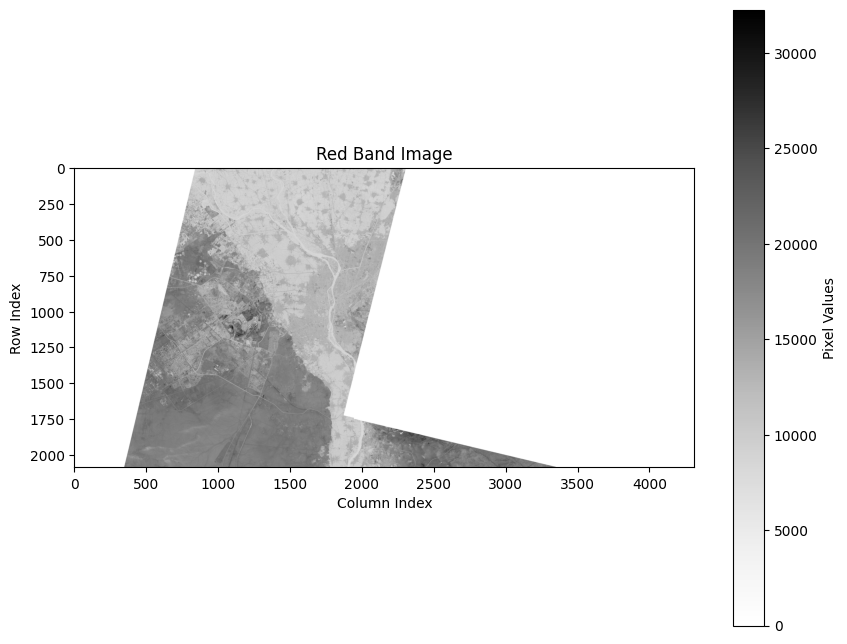

In [138]:
band_to_plot = 0
red_image = ds_composite[band_to_plot, :, :]

plt.figure(figsize=(10, 8))
plt.imshow(red_image, cmap='Greys')  
plt.colorbar(label='Pixel Values') 
plt.title(f"Red Band Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

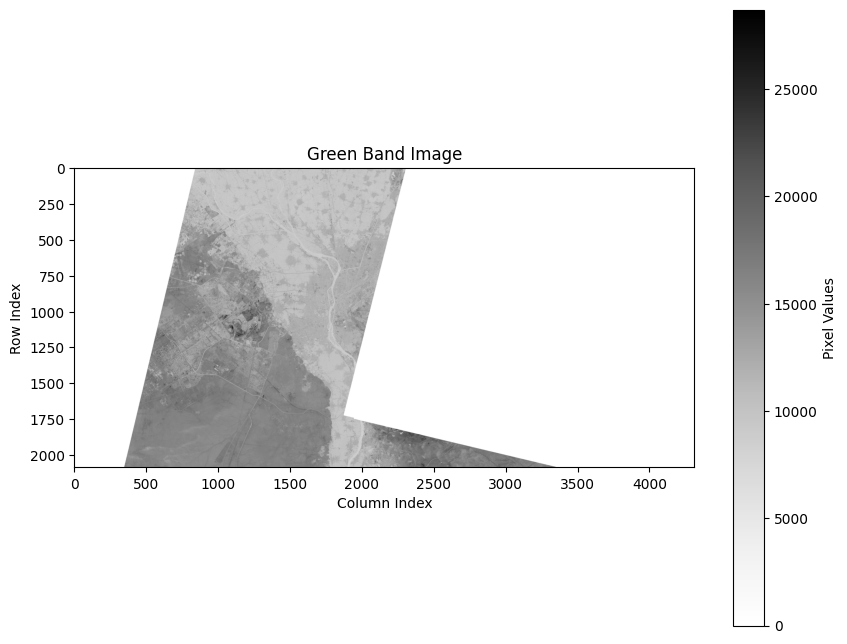

In [139]:
band_to_plot = 1
green_image = ds_composite[band_to_plot, :, :]

plt.figure(figsize=(10, 8))
plt.imshow(green_image, cmap='Greys')  
plt.colorbar(label='Pixel Values') 
plt.title(f"Green Band Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

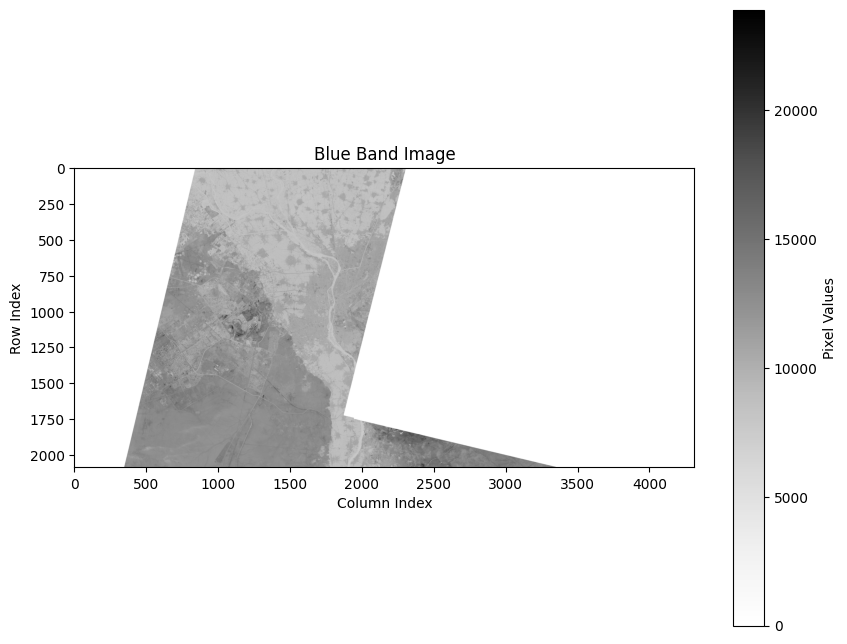

In [140]:
band_to_plot = 2
blue_image = ds_composite[band_to_plot, :, :] 

plt.figure(figsize=(10, 8))
plt.imshow(blue_image, cmap='Greys')  
plt.colorbar(label='Pixel Values') 
plt.title(f"Blue Band Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [141]:
rgb_image = np.stack((red_image, green_image, blue_image), axis=-1)

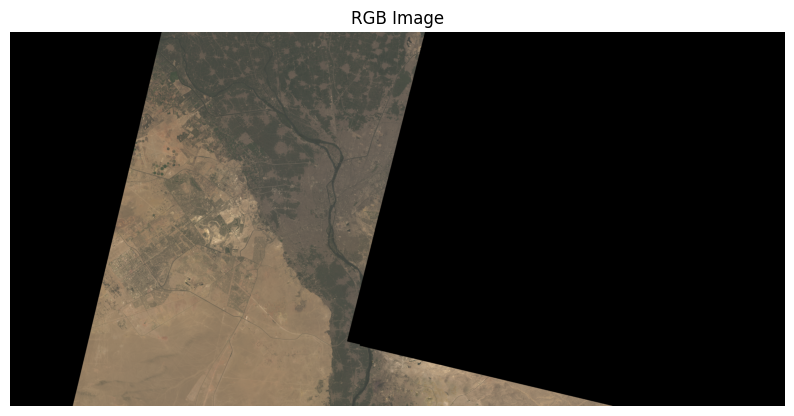

In [142]:
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

plt.figure(figsize=(10, 8))
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.axis("off")
plt.show()